In [1]:
import pandas as pd
import yaml
import pickle
import os
import logging
from utilities.utilities import *
from utilities.plotting import plot_exposure_map, plot_exposure_contour, plot_gdp_increase_map, plot_gdp_increase_scatter
from utilities.plotting import plot_variable_map, plot_cdd_scatter, plot_variable_histogram

In [2]:
# Load configuration from config.yaml
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)
logging.basicConfig(level=config['logging_level'])

with open('exposure_function_params_{0}.pkl'.format(config['availability_function']), 'rb') as f:
    params = pickle.load(f)

if config['availability_function'] == 'power_law':
    avail_func = power_avail
elif config['availability_function'] == 'exponential':
    avail_func = exp_avail
elif config['availability_function'] == 'combined_exponential':
    avail_func = None
else:
    raise ValueError('Availability function not recognized')

def exposure_new(cdd, gdp):
    if avail_func is not None:
        return exposure_function((cdd, gdp), avail_func, params['cdd_scale'], params['alpha'], params['k'])
    else:
        return exposure_combined_exponential((cdd, gdp), params['cdd_scale'], params['alpha'], params['k'])

ref_year = config['analysis_years']['ref_year']
past_year = config['analysis_years']['past_year']
future_year = config['analysis_years']['future_year']

outfile_path = config['output_path']

In [3]:
# Collect country-level data, only recalculate if the file does not exist

if os.path.exists(outfile_path):
    logging.info('Reading in experienced temperature data from file {}'.format(outfile_path))
    # Read in the data
    ac_data = pd.read_csv(outfile_path)

else:
    logging.info('Heat exposure analysis results not found, recalculating')

    # Read the historical cooling degree days data
    cdd_data = read_cdd_data(config['cdd_historical_file'])
    

    # Read the historical GDP data
    gdp_data = read_gdp_data(config['gdp_historical_file'])
    gdp_data_years = []
    for year in [past_year, ref_year]:
        gdp_data_year = gdp_data[gdp_data['Year'] == year]
        fill_missing_country_gdp_data(year, gdp_data_year, config)
        if year == past_year:
            gdp_data_year = gdp_data_year.rename(columns={'GDP': 'GDP_past'})
            gdp_data_year = gdp_data_year.rename(columns={'Year': 'Year_past'})
        gdp_data_years.append(gdp_data_year)
    gdp_data = pd.merge(gdp_data_years[0], gdp_data_years[1], on='ISO3')

    ac_data_historical = pd.merge(cdd_data, gdp_data, on=['ISO3', 'Year'], how='left')
    ac_data_historical = ac_data_historical.rename(columns={'Year': 'Year_ref'})
        
    # Add historical annual GDP growth
    ac_data_historical['gdp_historical_growth'] = calculate_average_gdp_growth(ac_data_historical['GDP'], 
            ac_data_historical['GDP_past'], ac_data_historical['Year_ref'] - ac_data_historical['Year_past'])

    # Add predictions for CDD in 2100 in different scenarios
    cdd_projections = read_projections(config, 'cdd', ac_data_historical, year=config['analysis_years']['future_year'])
    
    # Combine historical and projections into one dataframe
    ac_data = pd.merge(ac_data_historical, cdd_projections, on='ISO3', how='outer')

    # Formatting
    # Drop rows where year past is NaN
    ac_data = ac_data.dropna(subset=['Year_past'])
    ac_data.reset_index(drop=True, inplace=True)
    ac_data['Year_past'] = ac_data['Year_past'].astype(int)
    # Replace infinities with empty values
    ac_data = ac_data.replace(np.inf, np.nan)

    # Add column for historical heat exposure
    print(ac_data)
    ac_data['exposure_times_cdd'] = exposure_new(ac_data['CDD'], ac_data['GDP'])*ac_data['CDD']

    # Sort by income quantile and label each country with income group
    ac_data['income_group'] = pd.qcut(ac_data['GDP'], 5, labels=config['income_groups'])
    
    # Calculate GDP needed to keep heat exposure constant
    ac_data = calculate_gdp_const(ac_data, config, params)

    # Write full dataframe to csv
    if not os.path.exists(outfile_path):
        ac_data.to_csv(outfile_path)


INFO:root:Reading in experienced temperature data from file data_experiencedT/heat_exposure_calculations.csv


In [4]:
# Get income group averages of CDD and GDP
ac_data_income_group = ac_data.drop(columns=['ISO3', 'Country'])
ac_data_income_group = ac_data_income_group.groupby('income_group').mean()
# Add row for global average
ac_data_income_group.loc['global average'] = ac_data_income_group.mean()

# Calculate GDP needed to keep exposure times CDD constant
for scenario in config['future_scenarios']:
    ac_data_income_group = calculate_gdp_const(ac_data_income_group, config, params)

# Recalculate exposure times CDD for income groups
ac_data_income_group['exposure_times_cdd'] = exposure_new(ac_data_income_group['CDD'], ac_data_income_group['GDP'])*ac_data_income_group['CDD']

INFO:root:Infinite GDP calculated for Index([], dtype='object', name='income_group'), possibly 0 CDD
INFO:root:Infinite GDP calculated for Index([], dtype='object', name='income_group'), possibly 0 CDD
INFO:root:Infinite GDP calculated for Index([], dtype='object', name='income_group'), possibly 0 CDD
INFO:root:Infinite GDP calculated for Index([], dtype='object', name='income_group'), possibly 0 CDD
INFO:root:Infinite GDP calculated for Index([], dtype='object', name='income_group'), possibly 0 CDD
INFO:root:Infinite GDP calculated for Index([], dtype='object', name='income_group'), possibly 0 CDD
INFO:root:Infinite GDP calculated for Index([], dtype='object', name='income_group'), possibly 0 CDD
INFO:root:Infinite GDP calculated for Index([], dtype='object', name='income_group'), possibly 0 CDD
INFO:root:Infinite GDP calculated for Index([], dtype='object', name='income_group'), possibly 0 CDD


In [5]:
# Add CDD difference between 2100 and ref year
for scenario in config['future_scenarios']:
    ac_data['CDD_{0}_{1}_diff'.format(scenario, future_year)] = ac_data['CDD_{0}_{1}'.format(scenario, future_year)] - ac_data['CDD']

In [6]:
print(ac_data[ac_data['GDP_past'] > ac_data['GDP']])
# print when future CDD is less than past CDD
print(ac_data[ac_data['CDD_ssp2_rcp45_2100'] < ac_data['CDD']])

     Unnamed: 0 ISO3                           Country         CDD  Year_ref  \
12           12  BHS                           Bahamas  2783.32722      2019   
26           26  BRN                 Brunei Darussalam  3447.11289      2019   
29           29  BDI                           Burundi  1078.00996      2019   
34           34  CYM                    Cayman Islands  3373.68059      2019   
35           35  CAF          Central African Republic  3003.84314      2019   
44           44  CUW      Curacao/Netherlands Antilles  3232.31097      2019   
48           48  COD  Democratic Republic of the Congo  2184.36589      2019   
65           65  GAB                             Gabon  2767.92130      2019   
76           76  GNB                     Guinea-Bissau  3557.95151      2019   
78           78  HTI                             Haiti  2759.37184      2019   
96           96  KIR                          Kiribati  3543.26065      2019   
105         105  LBR                    

/carnegie/nobackup/scratch/awongel/clab_experiencedT/utilities/plotting_classes.py:82: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
/carnegie/nobackup/scratch/awongel/clab_experiencedT/utilities/plotting_classes.py:82: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
/carnegie/nobackup/scratch/awongel/clab_experiencedT/utilities/plotting_classes.py:82: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https:

<Figure size 640x480 with 0 Axes>

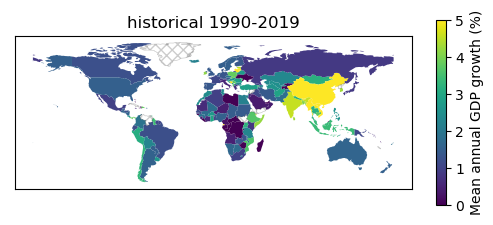

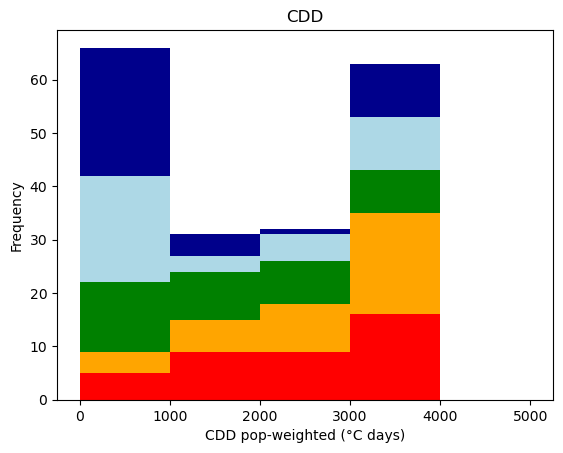

<Figure size 640x480 with 0 Axes>

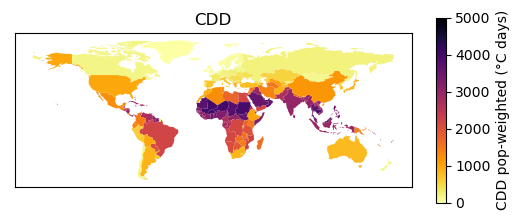

<Figure size 640x480 with 0 Axes>

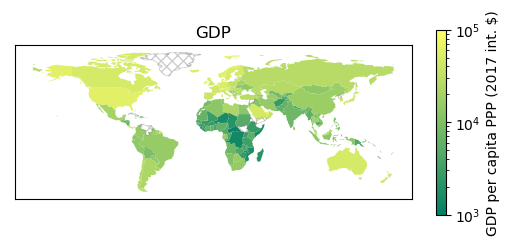

/home/awongel/miniconda3/envs/experiencedT_env/lib/python3.10/site-packages/matplotlib/text.py:1419: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(x))
/home/awongel/miniconda3/envs/experiencedT_env/lib/python3.10/site-packages/matplotlib/text.py:1421: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))
/home/awongel/miniconda3/envs/experiencedT_env/lib/python3.10/site-packages/matplotlib/text.py:830: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
/home/awongel/miniconda3/envs/experiencedT_env/lib/python3.10/site-packages/matplotlib/text.py:831: FutureWarning: Calling float on a single element Series

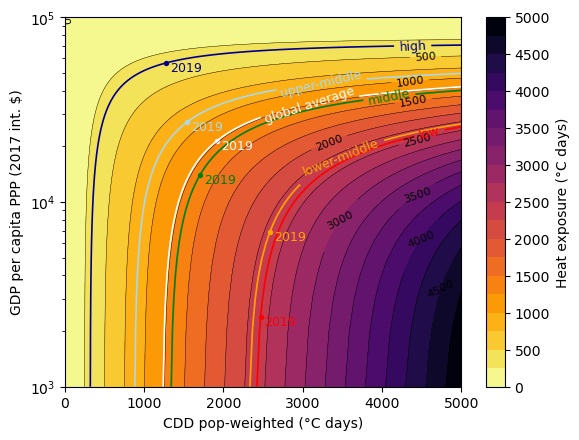

<Figure size 640x480 with 0 Axes>

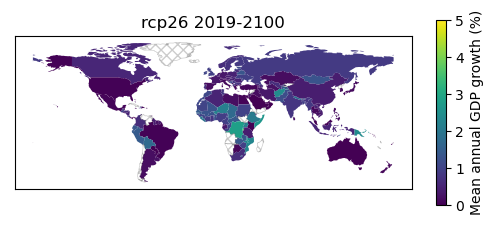

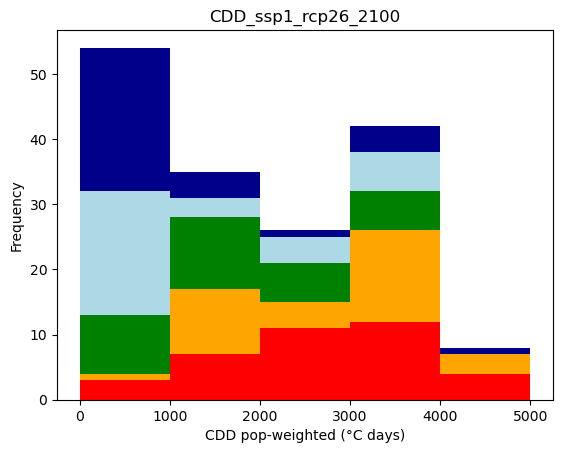

<Figure size 640x480 with 0 Axes>

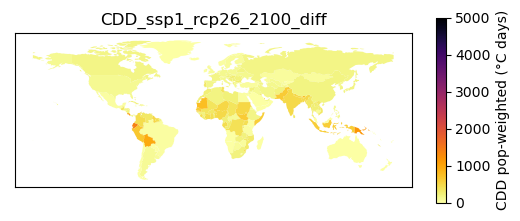

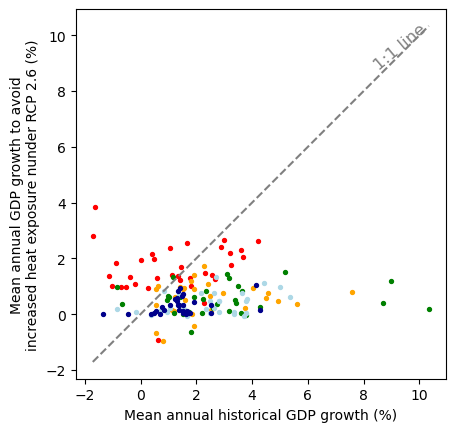

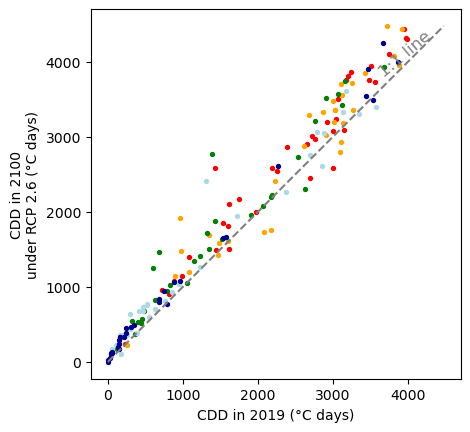

<Figure size 640x480 with 0 Axes>

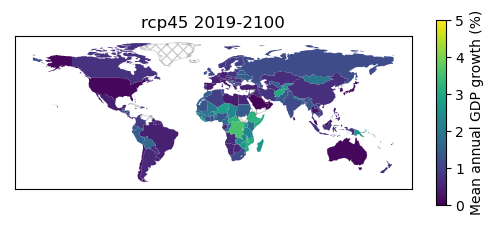

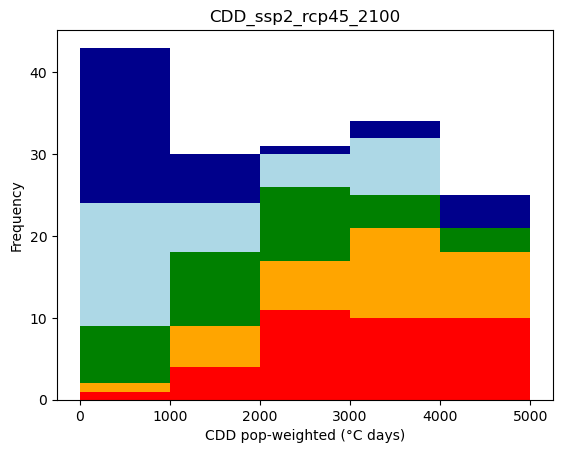

<Figure size 640x480 with 0 Axes>

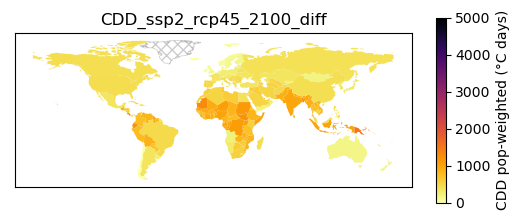

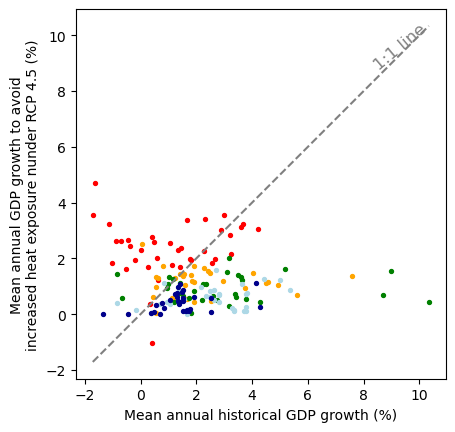

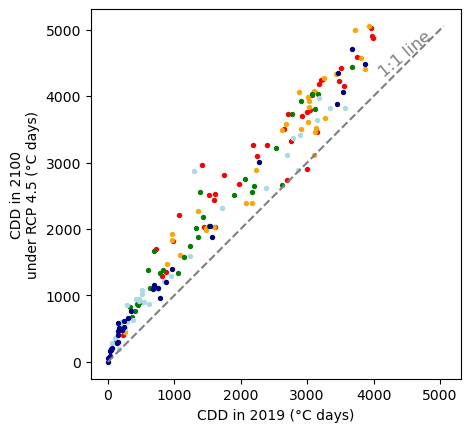

<Figure size 640x480 with 0 Axes>

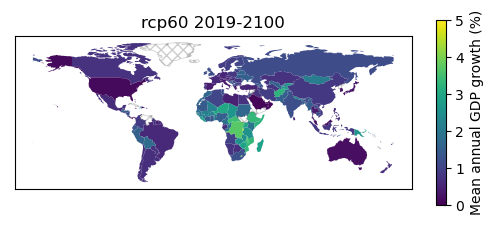

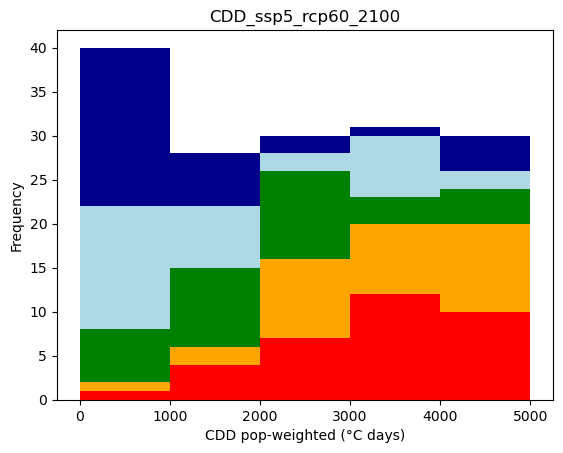

<Figure size 640x480 with 0 Axes>

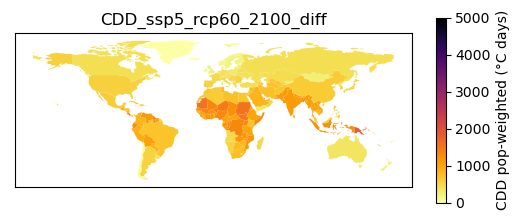

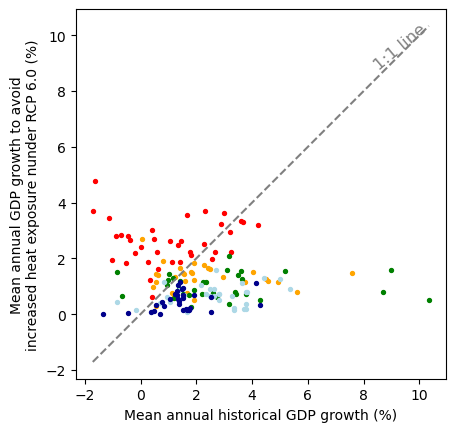

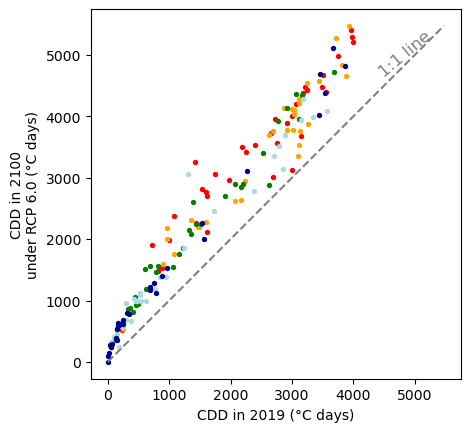

In [7]:
# Make all plots

for scenario in ['historical'] + config['future_scenarios']:

    # Parts of Figure GDP growth (Fig.3)
    plot_gdp_increase_map(config, ac_data, scenario)

    # Parts of Figure CDD change (Fig.2)
    if scenario == 'historical':
        scen = ''
        vars = ['CDD', 'GDP']
    else:
        scen = '_'+scenario+'_2100'
        vars = ['CDD_{}_2100_diff'.format(scenario)]
    plot_variable_histogram(config, ac_data, 'CDD'+scen)
    
    # Part of Figure Contour Map (Fig.1) and Figure CDD change (Fig.2)
    for var in vars:
        plot_variable_map(config, ac_data, var)
    
    if scenario == 'historical':
    
        # Part of Figure Contour Map (Fig.1)
        # Plot exposure contour
        plot_exposure_contour(config, exposure_new, ac_data_income_group, 
                    x_y_ranges=[[config['plotting']['cdd_min'], config['plotting']['cdd_max'], 100],
                                    [config['plotting']['gdp_min'], config['plotting']['gdp_max'], 100]], 
                    name_tag='exposure_contour')
        continue

    # Part of Figure GDP growth (Fig.2)
    plot_gdp_increase_scatter(config, ac_data, scenario)

    # Part of Figure CDD change (Fig.3)
    plot_cdd_scatter(config, ac_data, scenario)

# Figure 3
# Plot contour for each income group with x and y percent increase in CDD and GDP
# x_max = [4.5, 3., 2., 1.25, 0.25, 1.5]
# for i, income_group in enumerate(config['income_groups_colors'].keys()):
#     if income_group == 'high':
#         neg_cdd = 10
#         neg_gdp = 0.2
#     else:
#         neg_cdd = 0.
#         neg_gdp = 0.
#     plot_exposure_contour(config, exposure_new, ac_data_income_group, x_y_ranges=[[0-neg_cdd, 60, 100],[0-neg_gdp, x_max[i], 100]],
#                     country=income_group, name_tag='exposure_contour_{}'.format(income_group))


    
